In [1]:
import tensorflow as tf
import torch

import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np

from kan import *
import time

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import csv

from sklearn.model_selection import KFold

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression, f_regression, chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder

In [2]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
cuda


In [3]:
# read dataset
df = pd.read_csv("Dataset/lead_scoring/Leads.csv")

In [4]:
# preprocessing steps for numerical and categorical data (remove id, drop constant, replace missing value, encode, scale)
# drop id
df = df.drop(["Prospect ID", "Lead Number"], axis = 1)

# drop columns with only 1 distinct value
cat_cols = [col for col in df.select_dtypes(exclude = np.number).columns]
x = df[cat_cols].nunique()
cols_to_drop = list(x[x < 2].index)
df.drop(cols_to_drop, axis = 1, inplace = True)

# replace select to null value (later will change to Unknown)
df.replace('Select', '', inplace=True)

numeric_features = df.drop(["Converted"], axis = 1).select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

features = preprocessor.fit_transform(df)
target = df['Converted']

In [5]:
# # preprocessing steps for numerical and categorical data (remove id, drop constant, replace missing value, encode, scale)
# # drop id
# df = df.drop(["Prospect ID", "Lead Number"], axis = 1)

# # drop columns with only 1 distinct value
# cat_cols = [col for col in df.select_dtypes(exclude = np.number).columns]
# x = df[cat_cols].nunique()
# cols_to_drop = list(x[x < 2].index)
# df.drop(cols_to_drop, axis = 1, inplace = True)

# # replace select to null value (later will change to Unknown)
# df.replace('Select', '', inplace=True)

# # replace NaN and empty values
# numerical_cols = df.select_dtypes(exclude=['object']).columns
# categorical_cols = df.select_dtypes(include=['object']).columns

# # for column in categorical_cols:
# #     df[column] = df[column].replace(to_replace=[np.nan, '', 'nan'], value='Unknown')
    
# for column in numerical_cols:
#     df[column] = pd.to_numeric(df[column], errors='coerce')
#     df[column] = df[column].fillna(0)

# scaler = StandardScaler()
# ohe = OneHotEncoder(drop='first', sparse_output=False)

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', scaler, numerical_cols),
#         ('cat', ohe, categorical_cols)
#     ]
# )

# features = preprocessor.fit_transform(df)
# target = df['Converted']

In [6]:
# from gitfront.io
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.6, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_input = torch.tensor(X_train.todense(), dtype=torch.float32).to(device)
test_input = torch.tensor(X_test.todense(), dtype=torch.float32).to(device)
val_input = torch.tensor(X_val.todense(), dtype=torch.float32).to(device)

train_label = torch.tensor(np.array(y_train).reshape(-1, 1), dtype=torch.float32).to(device)
test_label = torch.tensor(np.array(y_test).reshape(-1, 1), dtype=torch.float32).to(device)
val_label = torch.tensor(np.array(y_val).reshape(-1, 1), dtype=torch.float32).to(device)

dataset = {
    'train_input' : train_input,
    'test_input'  : test_input,
    'train_label' : train_label,
    'test_label'  : test_label,
    'val_input'   : val_input,
    'val_label'   : val_label
}

In [7]:
# # X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.2, random_state=42)
# # X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
# X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.6, random_state=42)
# X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# train_input = torch.tensor(X_train, dtype=torch.float32).to(device)
# test_input = torch.tensor(X_test, dtype=torch.float32).to(device)
# val_input = torch.tensor(X_val, dtype=torch.float32).to(device)

# train_label = torch.tensor(np.array(y_train).reshape(-1, 1), dtype=torch.float32).to(device)
# test_label = torch.tensor(np.array(y_test).reshape(-1, 1), dtype=torch.float32).to(device)
# val_label = torch.tensor(np.array(y_val).reshape(-1, 1), dtype=torch.float32).to(device)

# dataset = {
#     'train_input' : train_input,
#     'test_input'  : test_input,
#     'train_label' : train_label,
#     'test_label'  : test_label,
#     'val_input'   : val_input,
#     'val_label'   : val_label
# }

In [8]:
def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).float())

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).float())

In [9]:
torch.cuda.empty_cache()

In [10]:
st = time.time()

# best_model = {'grid': 50, 'k': 5, 'step': 100, 'lamb': 0, 'lamb_entropy': 0}

# model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=best_model['grid'], k=best_model['k'], device=device).to(device)
# final_result = model.train(dataset, opt="LBFGS", steps=best_model['step'], lamb=best_model['lamb'], lamb_entropy=best_model['lamb_entropy'], metrics=(train_acc, test_acc), device=device)
model = KAN(width=[dataset['train_input'].shape[1], 3, 1], device=device).to(device)
final_result = model.train(dataset, metrics=(train_acc, test_acc), device=device)

et = time.time()
duration_b4 = et-st

print("Accuracy", final_result['train_acc'][-1], final_result['test_acc'][-1])
print("Duration", duration_b4)

train loss: 1.91e-01 | test loss: 2.15e-01 | reg: 2.19e+02 : 100%|█| 100/100 [23:08<00:00, 13.89s/it

Accuracy 0.9561688303947449 0.9430014491081238
Duration 1388.5618779659271


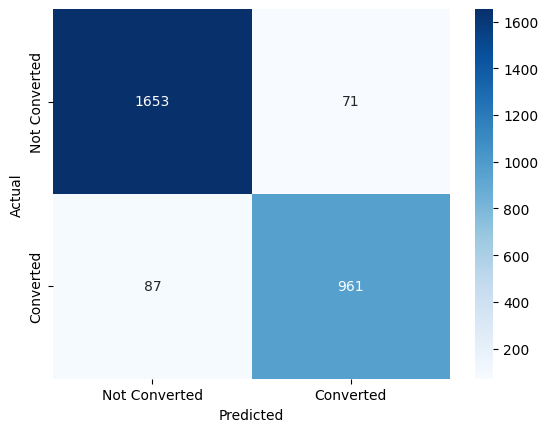

Accuracy: 0.943001443001443
Precision: 0.9312015503875969
Recall: 0.9169847328244275
F1 Score: 0.9240384615384615


In [11]:
# get predicted values
with torch.no_grad():
    test_inputs = dataset['test_input'].clone().detach().to(device)
    actual_labels = dataset['test_label'].clone().detach().to(device)
    predicted_probs = model(test_inputs)
    predicted_labels = (predicted_probs > 0.5).float()
    
y_pred = predicted_labels.cpu().numpy()
y_true = actual_labels.cpu().numpy()

conf_matrix = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

accuracy_b4 = (tn+tp)/(tn+fp+fn+tp)
precision_b4 = tp / (tp + fp) if (tp + fp) != 0 else 0
recall_b4 = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_score_b4 = 2 * (precision_b4 * recall_b4) / (precision_b4 + recall_b4) if (precision_b4 + recall_b4) != 0 else 0

# confusion matrix heatmap
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# performance metrics
print(f'Accuracy: {accuracy_b4}')
print(f'Precision: {precision_b4}')
print(f'Recall: {recall_b4}')
print(f'F1 Score: {f1_score_b4}')

In [12]:
# fine-tune grid
st = time.time()

grid_values = [1, 3, 5, 7]
results = []

for grid_val in grid_values:
    print(f"\nTraining with grid = {grid_val}")
    
    st = time.time()
    
    model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=grid_val, device=device).to(device)
    final_result = model.train(dataset, opt="LBFGS", metrics=(train_acc, test_acc), device=device)
    
    et = time.time()
    duration = et - st
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]

    print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, Duration: {duration:.2f} sec")


Training with grid = 1


train loss: 1.89e-01 | test loss: 2.16e-01 | reg: 3.96e+02 : 100%|█| 100/100 [23:57<00:00, 14.37s/it


Train Accuracy: 0.9570, Test Accuracy: 0.9437, Duration: 1437.36 sec

Training with grid = 3


train loss: 1.72e-01 | test loss: 3.22e-01 | reg: 2.59e+02 : 100%|█| 100/100 [23:09<00:00, 13.89s/it


Train Accuracy: 0.9656, Test Accuracy: 0.9318, Duration: 1389.45 sec

Training with grid = 5


train loss: 1.72e-01 | test loss: 2.26e-01 | reg: 2.12e+02 : 100%|█| 100/100 [23:42<00:00, 14.22s/it


Train Accuracy: 0.9646, Test Accuracy: 0.9361, Duration: 1422.43 sec

Training with grid = 7


train loss: 1.66e-01 | test loss: 2.64e-01 | reg: 1.29e+02 : 100%|█| 100/100 [23:06<00:00, 13.86s/it

Train Accuracy: 0.9692, Test Accuracy: 0.9318, Duration: 1386.52 sec


In [ ]:
# here

In [13]:
# fine-tune k
st = time.time()

k_values = [1, 3, 5, 7]
results = []

for k_val in k_values:
    print(f"\nTraining with k = {k_val}")
    
    st = time.time()
    
    model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=1, k=k_val, device=device).to(device)
    final_result = model.train(dataset, opt="LBFGS", metrics=(train_acc, test_acc), device=device)
    
    et = time.time()
    duration = et - st
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]

    print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, Duration: {duration:.2f} sec")


Training with k = 1


train loss: 2.02e-01 | test loss: 2.19e-01 | reg: 4.55e+02 : 100%|█| 100/100 [22:05<00:00, 13.25s/it


Train Accuracy: 0.9518, Test Accuracy: 0.9434, Duration: 1325.10 sec

Training with k = 3


train loss: 1.96e-01 | test loss: 2.16e-01 | reg: 6.11e+02 : 100%|█| 100/100 [23:37<00:00, 14.18s/it


Train Accuracy: 0.9521, Test Accuracy: 0.9448, Duration: 1417.90 sec

Training with k = 5


train loss: 1.85e-01 | test loss: 2.25e-01 | reg: 3.61e+02 : 100%|█| 100/100 [23:26<00:00, 14.07s/it


Train Accuracy: 0.9602, Test Accuracy: 0.9419, Duration: 1406.77 sec

Training with k = 7


train loss: 2.07e-01 | test loss: 2.25e-01 | reg: 5.29e+02 : 100%|█| 100/100 [24:27<00:00, 14.68s/it

Train Accuracy: 0.9499, Test Accuracy: 0.9387, Duration: 1467.84 sec


In [14]:
# fine-tune step
st = time.time()

step_values = [25, 50, 75, 100]
results = []

for step_val in step_values:
    print(f"\nTraining with step = {step_val}")
    
    st = time.time()
    
    model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=1, k=3, device=device).to(device)
    final_result = model.train(dataset, opt="LBFGS", steps=step_val, metrics=(train_acc, test_acc), device=device)
    
    et = time.time()
    duration = et - st
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]

    print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, Duration: {duration:.2f} sec")


Training with step = 25


train loss: 2.04e-01 | test loss: 2.16e-01 | reg: 4.48e+02 : 100%|██| 25/25 [06:08<00:00, 14.76s/it]


Train Accuracy: 0.9521, Test Accuracy: 0.9419, Duration: 368.98 sec

Training with step = 50


train loss: 2.02e-01 | test loss: 2.16e-01 | reg: 4.84e+02 : 100%|██| 50/50 [12:17<00:00, 14.75s/it]


Train Accuracy: 0.9527, Test Accuracy: 0.9437, Duration: 737.36 sec

Training with step = 75


train loss: 1.89e-01 | test loss: 2.18e-01 | reg: 4.86e+02 : 100%|██| 75/75 [18:04<00:00, 14.46s/it]


Train Accuracy: 0.9564, Test Accuracy: 0.9398, Duration: 1084.63 sec

Training with step = 100


train loss: 1.93e-01 | test loss: 2.15e-01 | reg: 5.15e+02 : 100%|█| 100/100 [24:22<00:00, 14.62s/it

Train Accuracy: 0.9540, Test Accuracy: 0.9423, Duration: 1462.41 sec


In [15]:
# fine-tune lamb
st = time.time()

lamb_values = [0, 0.1, 0.01, 0.001]
results = []

for lamb_val in lamb_values:
    print(f"\nTraining with lamb = {lamb_values}")
    
    st = time.time()
    
    model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=1, k=3, device=device).to(device)
    final_result = model.train(dataset, opt="LBFGS", steps=50, lamb=lamb_val, metrics=(train_acc, test_acc), device=device)
    
    et = time.time()
    duration = et - st
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]

    print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, Duration: {duration:.2f} sec")


Training with lamb = [0, 0.1, 0.01, 0.001]


train loss: 1.94e-01 | test loss: 2.13e-01 | reg: 4.16e+02 : 100%|██| 50/50 [12:14<00:00, 14.70s/it]


Train Accuracy: 0.9543, Test Accuracy: 0.9452, Duration: 734.84 sec

Training with lamb = [0, 0.1, 0.01, 0.001]


train loss: 6.49e-01 | test loss: 6.49e-01 | reg: 3.47e+01 : 100%|██| 50/50 [04:03<00:00,  4.87s/it]


Train Accuracy: 0.5419, Test Accuracy: 0.5321, Duration: 243.74 sec

Training with lamb = [0, 0.1, 0.01, 0.001]


train loss: 5.26e-01 | test loss: 5.23e-01 | reg: 3.43e+01 : 100%|██| 50/50 [07:47<00:00,  9.36s/it]


Train Accuracy: 0.5749, Test Accuracy: 0.5927, Duration: 467.77 sec

Training with lamb = [0, 0.1, 0.01, 0.001]


train loss: 2.88e-01 | test loss: 2.85e-01 | reg: 3.46e+01 : 100%|██| 50/50 [07:06<00:00,  8.53s/it]

Train Accuracy: 0.8999, Test Accuracy: 0.9058, Duration: 426.39 sec


train loss: 1.97e-01 | test loss: 2.14e-01 | reg: 4.74e+02 : 100%|██| 50/50 [12:26<00:00, 14.93s/it]

Accuracy 0.9521104097366333 0.9433621764183044
Duration 746.5662672519684


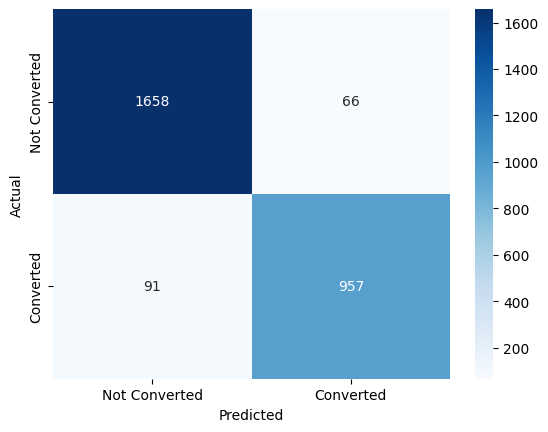

Accuracy: 0.9433621933621934
Precision: 0.9354838709677419
Recall: 0.9131679389312977
F1 Score: 0.9241912119748912


In [16]:
# after fine-tune
st = time.time()

best_model = {'grid': 1, 'k': 3, 'step': 50, 'lamb': 0, 'lamb_entropy': 0}

model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=best_model['grid'], k=best_model['k'], device=device).to(device)
final_result = model.train(dataset, opt="LBFGS", steps=best_model['step'], lamb=best_model['lamb'], lamb_entropy=best_model['lamb_entropy'], metrics=(train_acc, test_acc), device=device)

et = time.time()
duration = et-st

print("Accuracy", final_result['train_acc'][-1], final_result['test_acc'][-1])
print("Duration", duration)

# get predicted values
with torch.no_grad():
    test_inputs = dataset['test_input'].clone().detach().to(device)
    actual_labels = dataset['test_label'].clone().detach().to(device)
    predicted_probs = model(test_inputs)
    predicted_labels = (predicted_probs > 0.5).float()
    
y_pred = predicted_labels.cpu().numpy()
y_true = actual_labels.cpu().numpy()

conf_matrix = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

accuracy = (tn+tp)/(tn+fp+fn+tp)
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# confusion matrix heatmap
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# performance metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')

In [17]:
# save to csv
# filename = "KAN_performance.csv"
filename = "29.csv"
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Metric", "Before", "After"])
    writer.writerow(["Accuracy", accuracy_b4, accuracy])
    writer.writerow(["Precision", precision_b4, precision])
    writer.writerow(["Recall", recall_b4, recall])
    writer.writerow(["F1 Score", f1_score_b4, f1_score])
    writer.writerow(["Duration", duration_b4, duration])